In [1]:
import os
import sys
import time
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import tensorflow as tf
print(tf.__version__)
try:
    import keras
except:
    import tensorflow.keras as keras
print(keras.__version__)

from keras.layers import Input, Dense, Conv1D, Conv2D, MaxPool1D, LSTM, Lambda, Concatenate, Reshape, Permute, Multiply, Add, Softmax, ReLU, Dropout, Flatten, Dot  

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

1.14.0
2.2.4


Using TensorFlow backend.


In [2]:
def Preprocessing(auction, dataset_name, y_type, normalization_type, split_type, input_length):
    
    data=np.load(auction+'_'+dataset_name+'.npy')
    break_points=[0]+list(np.load(auction+'_n_ticks.npy').T.flatten().cumsum())
    print(data.shape)
    y_type_dict={'y1':40,'y2':41,'y5':42,'y1true':43,'y2true':44,'y5true':45}
    x=[]
    y=[]
    
    if not 'sample' in normalization_type:
        # split data by stock and day
        data=np.array([[data[break_points[stock*10+day]:break_points[stock*10+day+1]] for day in range(10)] 
                       for stock in range(5)])

        if 'stationary' in normalization_type:
            for stock in range(5):
                for day in range(10):
                    data[stock][day][:,:40]=data[stock][day][:,:40]-np.roll(data[stock][day][:,:40],1,axis=0)

        normalization_factors=np.tile(np.stack((np.zeros([5, 10]),np.ones([5, 10])), axis=0), (2,1,1))
        if normalization_type=='none':
            pass
        elif 'stock' in normalization_type and not 'day' in normalization_type:    
            for stock in range(5):
                training_data=np.vstack(data[stock][:5])
                for i in range(2):
                    normalization_factors[i*2+0, stock]=np.mean(training_data[:,range(i,40,2)])
                    normalization_factors[i*2+1, stock]=np.std (training_data[:,range(i,40,2)])
        elif 'day' in normalization_type:
            for stock in range(5):
                for day in range(10):
                    training_data=data[stock][max(day-1,0)]
                    for i in range(2):
                        normalization_factors[i*2+0, stock, day]=np.mean(training_data[:,range(i,40,2)])
                        normalization_factors[i*2+1, stock, day]=np.std (training_data[:,range(i,40,2)])     
        print(normalization_factors)

        for stock in range(5):
            for day in range(10):
                for field in range(2):
                    data[stock][day][:, range(field,40,2)]-=normalization_factors[field*2+0, stock, day]
                    data[stock][day][:, range(field,40,2)]/=normalization_factors[field*2+1, stock, day]
                valid_ticks=np.arange(input_length, len(data[stock][day])-5)+1
                x.append(np.expand_dims(data[stock][day][np.array([list(range(i-input_length,i)) for i in valid_ticks]), :40], axis=-1))
                y.append(np.eye(3)[data[stock][day][valid_ticks-1,y_type_dict[y_type]].astype(int)-1])
        x=np.array(x).reshape(5,10)
        y=np.array(y).reshape(5,10)
        
    else:
        # split data by stock and day
        idx = np.concatenate([np.concatenate((np.flip(np.arange(i+2,40,4)), np.arange(i,40,4))) for i in range(2)])
        data[:,:40]=data[:,:40][:,idx]
        data=np.array([[data[break_points[stock*10+day]:break_points[stock*10+day+1]] for day in range(10)] 
                       for stock in range(5)])

        for stock in range(5):
            for day in range(10):
                valid_ticks=np.arange(input_length, len(data[stock][day])-5)
                x.append(data[stock][day][np.array([list(range(i-input_length,i+1)) for i in valid_ticks]), :40]
                         .reshape(-1,input_length+1,2,20))
                x[-1]=np.log10(x[-1]/(x[-1][:,:,:,9:11].mean(axis=(1,3)).reshape(-1,1,2,1)))
                y.append(np.eye(3)[data[stock][day][valid_ticks,y_type_dict[y_type]].astype(int)-1])
        x=np.array(x).reshape(5,10)
        y=np.array(y).reshape(5,10)
        
        normalization_factors_mean=np.zeros([5,2,20])
        normalization_factors_std =np.zeros([5,2,20])
        for stock in range(5):
            training_data=np.concatenate(x[stock][:5]).reshape(-1,2,20)
            normalization_factors_mean[stock] = training_data.mean(axis=0)
            normalization_factors_std [stock] = training_data.std (axis=0)

        for stock in range(5):
            for day in range(10):
                x[stock][day]-=normalization_factors_mean[stock].reshape(1,1,2,20)
                x[stock][day]/=normalization_factors_std [stock].reshape(1,1,2,20)
                x[stock][day]=(x[stock][day]-np.roll(x[stock][day],1,axis=1))[:,1:]
                x[stock][day]=x[stock][day].reshape(-1,input_length,40,1)[:,:,np.argsort(idx)]
        
    data={'x':x, 'y':y}      
#     print(np.array([[len(data['x'][stock][day]) for day in range(10)] for stock in range(5)]))
#     print(np.array([[len(data['y'][stock][day]) for day in range(10)] for stock in range(5)]))
    
    # split into train, val, and test sets
    output={}
    if split_type=='default':
        output['train_x']=np.concatenate(np.array(data['x']).T[:5].flatten())
        output['train_y']=np.concatenate(np.array(data['y']).T[:5].flatten())
        output['val_x']  =np.concatenate(np.array(data['x']).T[5:7].flatten())
        output['val_y']  =np.concatenate(np.array(data['y']).T[5:7].flatten())
        output['test_x'] =np.concatenate(np.array(data['x']).T[7:].flatten())
        output['test_y'] =np.concatenate(np.array(data['y']).T[7:].flatten())

    _,axes=plt.subplots(1,3,figsize=(18,5), sharey=True)
    for i, split in enumerate(['train', 'val', 'test']):
        print(split, output[split+'_x'].shape, output[split+'_y'].shape)    
        _=axes[i].plot(output[split+'_x'][:,0,0,0])
    _=plt.show()
    
    return output

In [3]:
def BL(x, D_prime, T_prime, D, T):
    x = Conv2D(filters=D_prime, kernel_size=(D,1), activation=None,  use_bias=False)(x)
    x = Permute((3,2,1))(x)
    x = Conv2D(filters=T_prime, kernel_size=(1,T), activation='relu', use_bias=True)(x)
    x = Permute((1,3,2))(x)
    x = Dropout(rate=0.1)(x)
    return x

def TABL(x):
    x = Permute((2,1,3))(x)
    print(x.shape)
    x = BL(x, D_prime=60, T_prime=10, D=40, T=10)
    print(x.shape)
    x = BL(x, D_prime=120, T_prime=5, D=60, T=10)
    print(x.shape)
    
    x = Conv2D(filters=3, kernel_size=(120,1), activation=None, use_bias=False)(x)
    x = Permute((3,2,1))(x)
    e = Conv2D(filters=5, kernel_size=(1,5),   activation='softmax', use_bias=False, 
               kernel_initializer=keras.initializers.Constant(value=1/5))(x)  
    e = Permute((1,3,2))(e)
    x = Multiply()([x,e])
    print(x.shape)
    x = Conv2D(filters=1, kernel_size=(1,5),   activation=None, use_bias=True)(x)
    print(x.shape)
    x = Reshape((3,))(x)
    x = Softmax(axis=-1)(x)
    print(x.shape)
    return x

In [4]:
def Conv_module_PriceVolume(x, n_filters, alpha, upper_threshold, lower_threshold):
    x = Conv2D(filters=n_filters, kernel_size=(1,2), strides=(1,2))(x)
    x = ReLU(max_value=upper_threshold, negative_slope=alpha, threshold=lower_threshold)(x)
    print(x.shape)
    x = Conv2D(filters=n_filters, kernel_size=(4,1), padding='same')(x)
    x = ReLU(max_value=upper_threshold, negative_slope=alpha, threshold=lower_threshold)(x)
    print(x.shape)
    x = Conv2D(filters=n_filters, kernel_size=(4,1), padding='same')(x)
    x = ReLU(max_value=upper_threshold, negative_slope=alpha, threshold=lower_threshold)(x)
    print(x.shape)
    return x

def Conv_module_LOBdepth(x, n_filters, alpha, upper_threshold, lower_threshold):
    x = Conv2D(filters=n_filters, kernel_size=(1,10))(x)
    print(x.shape)
    x = Lambda(lambda x: keras.backend.squeeze(x, 2))(x)
    #   x = Reshape((100, n_filters))(x)
    x = ReLU(max_value=upper_threshold, negative_slope=alpha, threshold=lower_threshold)(x)
    print(x.shape)
    x = Conv1D(filters=n_filters, kernel_size=4, padding='same')(x)
    x = ReLU(max_value=upper_threshold, negative_slope=alpha, threshold=lower_threshold)(x)
    print(x.shape)
    x = Conv1D(filters=n_filters, kernel_size=4, padding='same')(x)
    x = ReLU(max_value=upper_threshold, negative_slope=alpha, threshold=lower_threshold)(x)
    print(x.shape)
    return x

def Inception_module(x, n_filters, alpha, upper_threshold, lower_threshold):
    x1 = Conv1D(filters=n_filters, kernel_size=1, padding='same')(x)
    x1 = ReLU(max_value=upper_threshold, negative_slope=alpha, threshold=lower_threshold)(x1)
    print(x1.shape)
    x1 = Conv1D(filters=n_filters, kernel_size=3, padding='same')(x1)
    x1 = ReLU(max_value=upper_threshold, negative_slope=alpha, threshold=lower_threshold)(x1)
    print(x1.shape)

    x2 = Conv1D(filters=n_filters, kernel_size=1, padding='same')(x)
    x2 = ReLU(max_value=upper_threshold, negative_slope=alpha, threshold=lower_threshold)(x2)
    print(x2.shape)
    x2 = Conv1D(filters=n_filters, kernel_size=5, padding='same')(x2)
    x2 = ReLU(max_value=upper_threshold, negative_slope=alpha, threshold=lower_threshold)(x2)
    print(x2.shape)

    x3 = MaxPool1D(pool_size=3, strides=1, padding='same')(x)
    print(x3.shape)
    x3 = Conv1D(filters=n_filters, kernel_size=1, padding='same')(x3)
    x3 = ReLU(max_value=upper_threshold, negative_slope=alpha, threshold=lower_threshold)(x3)
    print(x3.shape)

    x = Concatenate(axis=-1)([x1,x2,x3])
    print(x.shape)
    return x

def DeepLOB(x, alpha=0.01, upper_threshold=None, lower_threshold=0.0):
    x = Conv_module_PriceVolume(x, 16, alpha, upper_threshold, lower_threshold)
    x = Conv_module_PriceVolume(x, 16, alpha, upper_threshold, lower_threshold)
    x = Conv_module_LOBdepth(x, 16, alpha, upper_threshold, lower_threshold)
    x = Inception_module(x, 32, alpha, upper_threshold, lower_threshold)
    x = LSTM(units=64, implementation=2, unroll=True)(x)
    print(x.shape)
    x = Dense(3, activation='softmax')(x)
    print(x.shape)
    return x

In [5]:
def DeepLOB_clipped(x):
    return DeepLOB(x, alpha=0.0, upper_threshold=1.0, lower_threshold=0.0)

def Conv_module_LOBdepth_reversed(x, n_filters, alpha, upper_threshold, lower_threshold, p_filters=16, input_length=100):
    x = Permute((2,1,3))(x)
    print(x.shape)
    x = Reshape((10,input_length*2,p_filters))(x)
    print(x.shape)
    x = Conv2D(filters=n_filters, kernel_size=(10,1))(x)
    print(x.shape)
    x = ReLU(max_value=upper_threshold, negative_slope=alpha, threshold=lower_threshold)(x)
    print(x.shape)
    x = Reshape((2,input_length,n_filters))(x)
    print(x.shape)
    x = Permute((2,1,3))(x)
    print(x.shape)
    x = Conv2D(filters=n_filters, kernel_size=(4,1), padding='same')(x)
    x = ReLU(max_value=upper_threshold, negative_slope=alpha, threshold=lower_threshold)(x)
    print(x.shape)
    x = Conv2D(filters=n_filters, kernel_size=(4,1), padding='same')(x)
    x = ReLU(max_value=upper_threshold, negative_slope=alpha, threshold=lower_threshold)(x)
    print(x.shape)
    return x

def DeepLOB_reversed(x, alpha=0.01, upper_threshold=None, lower_threshold=0.0):
    x = Conv_module_PriceVolume(x, 16, alpha, upper_threshold, lower_threshold)
    x = Conv_module_LOBdepth_reversed(x, 16, alpha, upper_threshold, lower_threshold)
    x = Conv_module_PriceVolume(x, 16, alpha, upper_threshold, lower_threshold)
    x = Lambda(lambda x: keras.backend.squeeze(x, 2))(x)
    x = Inception_module(x, 32, alpha, upper_threshold, lower_threshold)
    x = LSTM(units=64, implementation=2, unroll=True)(x)
    print(x.shape)
    x = Dense(3, activation='softmax')(x)
    print(x.shape)
    return x

def DeepLOB_combined(x, alpha=0.01, upper_threshold=None, lower_threshold=0.0):
    x = Conv_module_PriceVolume(x, 16, alpha, upper_threshold, lower_threshold)
    x1 = Conv_module_PriceVolume(x, 8, alpha, upper_threshold, lower_threshold)
    x1 = Conv_module_LOBdepth(x1, 8, alpha, upper_threshold, lower_threshold)
    x2 = Conv_module_LOBdepth_reversed(x, 8, alpha, upper_threshold, lower_threshold)
    x2 = Conv_module_PriceVolume(x2, 8, alpha, upper_threshold, lower_threshold)
    x2 = Lambda(lambda x: keras.backend.squeeze(x, 2))(x2)
    print(x1.shape,x2.shape)
    x = Concatenate(axis=-1)([x1,x2])
    print(x.shape)
    x = Inception_module(x, 32, alpha, upper_threshold, lower_threshold)
    x = LSTM(units=64, implementation=2, unroll=True)(x)
    print(x.shape)
    x = Dense(3, activation='softmax')(x)
    print(x.shape)
    return x

def DeepLOB_noTimeConv(x, alpha=0.01, upper_threshold=None, lower_threshold=0.0):
    x = Conv2D(filters=16, kernel_size=(1,2), strides=(1,2))(x)
    x = ReLU(max_value=upper_threshold, negative_slope=alpha, threshold=lower_threshold)(x)
    print(x.shape)
    x = Conv2D(filters=16, kernel_size=(1,2), strides=(1,2))(x)
    x = ReLU(max_value=upper_threshold, negative_slope=alpha, threshold=lower_threshold)(x)
    print(x.shape)
    x = Conv2D(filters=16, kernel_size=(1,10))(x)
    print(x.shape)
    x = Lambda(lambda x: keras.backend.squeeze(x, 2))(x)
    x = ReLU(max_value=upper_threshold, negative_slope=alpha, threshold=lower_threshold)(x)
    print(x.shape)
    x = Inception_module(x, 32, alpha, upper_threshold, lower_threshold)
    x = LSTM(units=64, implementation=2, unroll=True)(x)
    print(x.shape)
    x = Dense(3, activation='softmax')(x)
    print(x.shape)
    return x

def DeepLOB_noInception(x, alpha=0.01, upper_threshold=None, lower_threshold=0.0):
    x = Conv_module_PriceVolume(x, 16, alpha, upper_threshold, lower_threshold)
    x = Conv_module_PriceVolume(x, 16, alpha, upper_threshold, lower_threshold)
    x = Conv_module_LOBdepth(x, 16, alpha, upper_threshold, lower_threshold)
    x = LSTM(units=64, implementation=2, unroll=True)(x)
    print(x.shape)
    x = Dense(3, activation='softmax')(x)
    print(x.shape)
    return x

def DeepLOB_noLSTM(x, alpha=0.01, upper_threshold=None, lower_threshold=0.0):
    x = Conv_module_PriceVolume(x, 16, alpha, upper_threshold, lower_threshold)
    x = Conv_module_PriceVolume(x, 16, alpha, upper_threshold, lower_threshold)
    x = Conv_module_LOBdepth(x, 16, alpha, upper_threshold, lower_threshold)
    x = Inception_module(x, 32, alpha, upper_threshold, lower_threshold)
    x = Flatten()(x)
    x = Dense(64)(x)
    print(x.shape)
    x = Dense(3, activation='softmax')(x)
    print(x.shape)
    return x

def DeepLOB_doubled(x, alpha=0.01, upper_threshold=None, lower_threshold=0.0):
    x = Conv_module_PriceVolume(x, 32, alpha, upper_threshold, lower_threshold)
    x = Conv_module_PriceVolume(x, 32, alpha, upper_threshold, lower_threshold)
    x = Conv_module_LOBdepth(x, 32, alpha, upper_threshold, lower_threshold)
    x = Inception_module(x, 64, alpha, upper_threshold, lower_threshold)
    x = LSTM(units=128, implementation=2, unroll=True)(x)
    print(x.shape)
    x = Dense(3, activation='softmax')(x)
    print(x.shape)
    return x

In [6]:
def Scaled_Dot_Product_Attention(x, n_filters=16, alpha=0.01, upper_threshold=None, lower_threshold=0.0):
    x1 = Conv1D(filters=n_filters, kernel_size=1)(x)
    x1 = ReLU(max_value=upper_threshold, negative_slope=alpha, threshold=lower_threshold)(x1)
    x2 = Conv1D(filters=n_filters, kernel_size=1)(x)
    x2 = ReLU(max_value=upper_threshold, negative_slope=alpha, threshold=lower_threshold)(x2)
    x3 = Conv1D(filters=n_filters, kernel_size=1)(x)
    x3 = ReLU(max_value=upper_threshold, negative_slope=alpha, threshold=lower_threshold)(x3)
#     print(x3.shape)
    x4 = Dot(axes=2, normalize=False)([x1,x2])
#     print(x4.shape)
    x4 = Lambda(lambda x: x/keras.backend.sqrt(keras.backend.cast(n_filters, 'float32')))(x4)
    x4 = Softmax(axis=1)(x4)
    x5 = Dot(axes=1, normalize=False)([x4,x3])
#     print(x5.shape)
    return x5

def Multi_head_Attention(x, n_heads=8, n_filters=16, alpha=0.01, upper_threshold=None, lower_threshold=0.0):
    x1 = [Scaled_Dot_Product_Attention(x, n_filters=n_filters, alpha=alpha, 
                                       upper_threshold=upper_threshold, lower_threshold=lower_threshold)
          for i in range(n_heads)]
    x = Concatenate(axis=-1)(x1)
    print(x.shape)
    return x

def DMALOB(x, alpha=0.01, upper_threshold=None, lower_threshold=0.0):
    x = Conv2D(filters=64, kernel_size=(1,2), strides=(1,2))(x)
    x = ReLU(max_value=upper_threshold, negative_slope=alpha, threshold=lower_threshold)(x)
    print(x.shape)
    x = Conv2D(filters=128, kernel_size=(1,2), strides=(1,2))(x)
    x = ReLU(max_value=upper_threshold, negative_slope=alpha, threshold=lower_threshold)(x)
    print(x.shape)
    x = Conv2D(filters=128, kernel_size=(1,10))(x)
    x = ReLU(max_value=upper_threshold, negative_slope=alpha, threshold=lower_threshold)(x)
    print(x.shape)
    x = Lambda(lambda x: keras.backend.squeeze(x, 2))(x)
    print(x.shape)
    x = Multi_head_Attention(x, alpha=alpha, upper_threshold=upper_threshold, lower_threshold=lower_threshold)
    x = Multi_head_Attention(x, alpha=alpha, upper_threshold=upper_threshold, lower_threshold=lower_threshold)
    x = Lambda(lambda x: x[:,-1])(x)
    print(x.shape)
    x = Dense(64)(x)
    print(x.shape)
    x = Dense(3, activation='softmax')(x)
    print(x.shape)
    return x


In [7]:
def GPU_setup(gpu_number, thread_number, allow_growth=True, allow_soft_placement=True):
    tf.reset_default_graph()
    keras.backend.clear_session()

    tf_config = tf.ConfigProto(allow_soft_placement=allow_soft_placement)
    tf_config.gpu_options.visible_device_list = str(gpu_number)
    tf_config.gpu_options.per_process_gpu_memory_fraction = 1/thread_number
    tf_config.gpu_options.allow_growth = allow_growth
    keras.backend.set_session(tf.Session(config=tf_config) )
    
def Train_model(train_x, train_y, val_x, val_y, model_name, lr, batch_size, output_folder, class_weight):
    models_list={'TABL':TABL, 'DeepLOB':DeepLOB,
                 'DeepLOB_clipped':DeepLOB_clipped, 'DeepLOB_reversed':DeepLOB_reversed, 
                 'DeepLOB_combined':DeepLOB_combined, 'DeepLOB_noTimeConv':DeepLOB_noTimeConv,
                 'DeepLOB_noInception':DeepLOB_noInception, 'DeepLOB_noLSTM':DeepLOB_noLSTM,
                 'DeepLOB_doubled':DeepLOB_doubled, 'DMALOB': DMALOB}
    epsilon=None if 'TABL' in model_name else 1
    start=time.time()
    inputs = Input(shape=train_x.shape[1:])
    outputs = models_list[model_name](inputs)
    model = keras.models.Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy', metrics=['categorical_accuracy'], 
                  optimizer=keras.optimizers.Adam(lr=lr, epsilon=epsilon))

    earlystopping = keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', min_delta=0, patience=10, 
                                                  verbose=1, mode='auto', baseline=None, restore_best_weights=True)
    csvlogger = keras.callbacks.CSVLogger(output_folder+'history.csv', separator=',', append=False)
    history = model.fit(train_x, train_y, validation_data=(val_x, val_y), batch_size=batch_size, epochs=200, 
                        shuffle=True, verbose=1, callbacks=[earlystopping, csvlogger], class_weight=class_weight) 
    
    model.save(output_folder+'model.hdf5')   
    
    training_time = int((time.time()-start)/60)
    print('training time used:', training_time//60, ':' , training_time%60)
    
    return model, history.history, training_time

def Plot_training_curve(history):
    _, axes=plt.subplots(1,2,figsize=(20,5))
    for i, metric in enumerate(['loss', 'categorical_accuracy']):
        for split in ['', 'val_']:
            _=axes[i].plot(history[split+metric], label=split+metric)
        _=axes[i].legend()
    plt.show()

def Get_test_results(model, test_x, test_y):
    predict_test_y=np.eye(test_y.shape[1])[np.argmax(model.predict(test_x, batch_size=2048, verbose=1), axis=1)]
    results = {'accuracy ': accuracy_score(test_y, predict_test_y)}
    results.update(zip(['precision', 'recall', 'f1_score'], precision_recall_fscore_support(test_y, predict_test_y, average='weighted')[:3]))

    print('\n'.join([item[0]+' '.join(['' for i in range(12-len(item[0]))])+str(item[1]) for item in results.items()]))
    print(confusion_matrix(np.argmax(test_y, axis=1), np.argmax(predict_test_y, axis=1)))
    print(precision_recall_fscore_support(test_y, predict_test_y, average=None))
    return results

def Save_information(preprocessing_parameters, training_parameters, results, training_time, history, output_folder):
    information={**preprocessing_parameters, **training_parameters, **results}
    information['training_time']=training_time
    information['epochs_trained']=len(history['loss'])
    information=json.dumps(information, separators=('\n ', ': '), sort_keys=False)
    print(information)
    with open(output_folder+'information.json', 'w') as f:
        f.write(information)
        
def Load_model(output_folder):
    model = keras.models.load_model(output_folder+'model.hdf5', custom_objects={'keras': keras})
    return model

def Load_information(output_folder):
    information=json.loads(open(output_folder+'information.json', 'r').read().replace('\n ', ', '))
    print(json.dumps(information, separators=('\n ', ': '), sort_keys=False))
    return information


(394337, 46)
[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

 [[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]

 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

 [[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]]
train (175627, 100, 40, 1) (175627, 3)
val (75448, 100, 40, 1) (75448, 3)
test (138012, 100, 40, 1) (138012, 3)


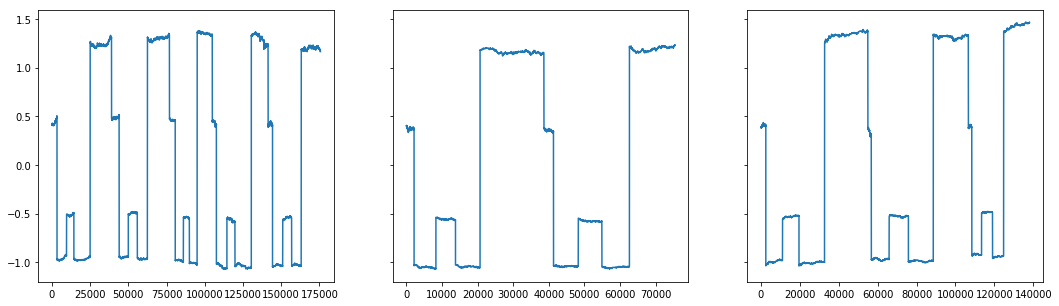

(?, 100, 20, 16)
(?, 100, 20, 16)
(?, 100, 20, 16)
(?, 100, 10, 16)
(?, 100, 10, 16)
(?, 100, 10, 16)
(?, 100, 1, 16)
(?, 100, 16)
(?, 100, 16)
(?, 100, 16)
(?, 100, 32)
(?, 100, 32)
(?, 100, 32)
(?, 100, 32)
(?, 100, 16)
(?, 100, 32)
(?, 100, 96)
(?, 64)
(?, 3)
Train on 175627 samples, validate on 75448 samples
Epoch 1/200
175627/175627 [==============================] - 517s 3ms/step - loss: 2.6895 - categorical_accuracy: 0.2629 - val_loss: 1.2029 - val_categorical_accuracy: 0.1626
Epoch 2/200
175627/175627 [==============================] - 482s 3ms/step - loss: 2.6777 - categorical_accuracy: 0.4133 - val_loss: 1.1233 - val_categorical_accuracy: 0.4096
Epoch 3/200
175627/175627 [==============================] - 483s 3ms/step - loss: 2.6739 - categorical_accuracy: 0.4395 - val_loss: 1.1158 - val_categorical_accuracy: 0.4119
Epoch 4/200
175627/175627 [==============================] - 482s 3ms/step - loss: 2.6481 - categorical_accuracy: 0.3685 - val_loss: 1.1437 - val_categorical_acc

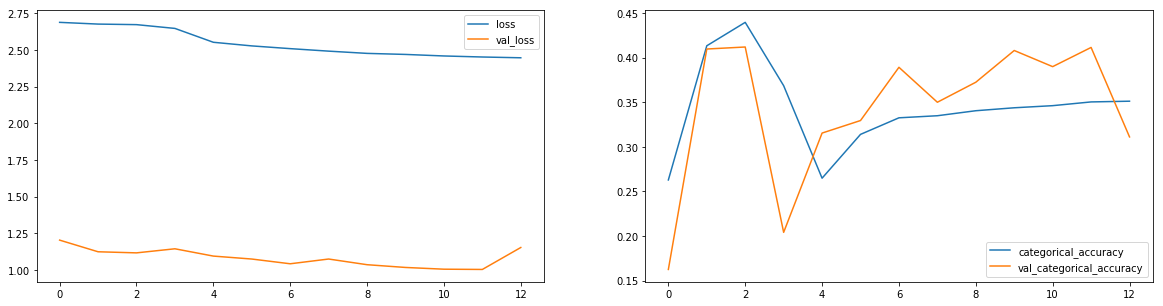

138012/138012 [==============================] - 9s 64us/step
accuracy   0.5533504332956555
precision  0.71959517589358
recall     0.5533504332956555
f1_score   0.6052740891908353
[[    8  6120  6682]
 [   64 70279 42822]
 [    0  5955  6082]]
(array([0.11111111, 0.85337689, 0.10941604]), array([0.00062451, 0.62103124, 0.5052754 ]), array([0.00124204, 0.71889688, 0.17987963]), array([ 12810, 113165,  12037]))
{"auction": "NoAuction"
 "dataset_name": "Zscore"
 "y_type": "y1true"
 "normalization_type": "none"
 "split_type": "default"
 "model_name": "DeepLOB"
 "lr": 0.01
 "batch_size": 32
 "accuracy ": 0.5533504332956555
 "precision": 0.71959517589358
 "recall": 0.5533504332956555
 "f1_score": 0.6052740891908353
 "training_time": 105
 "epochs_trained": 13}
(394337, 46)
[[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0

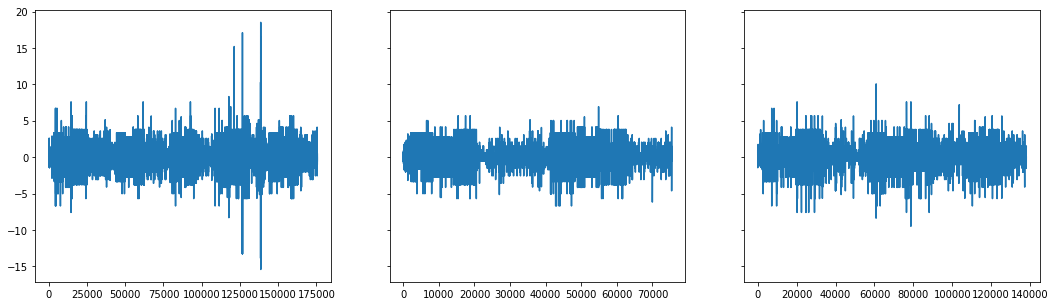

(?, 100, 20, 16)
(?, 100, 20, 16)
(?, 100, 20, 16)
(?, 100, 10, 16)
(?, 100, 10, 16)
(?, 100, 10, 16)
(?, 100, 1, 16)
(?, 100, 16)
(?, 100, 16)
(?, 100, 16)
(?, 100, 32)
(?, 100, 32)
(?, 100, 32)
(?, 100, 32)
(?, 100, 16)
(?, 100, 32)
(?, 100, 96)
(?, 64)
(?, 3)
Train on 175627 samples, validate on 75448 samples
Epoch 1/200
175627/175627 [==============================] - 517s 3ms/step - loss: 2.6653 - categorical_accuracy: 0.2726 - val_loss: 1.1246 - val_categorical_accuracy: 0.3539
Epoch 2/200
175627/175627 [==============================] - 483s 3ms/step - loss: 2.6147 - categorical_accuracy: 0.3482 - val_loss: 0.9045 - val_categorical_accuracy: 0.5727
Epoch 3/200
175627/175627 [==============================] - 483s 3ms/step - loss: 2.5392 - categorical_accuracy: 0.3109 - val_loss: 1.1081 - val_categorical_accuracy: 0.3211
Epoch 4/200
175627/175627 [==============================] - 483s 3ms/step - loss: 2.5004 - categorical_accuracy: 0.3275 - val_loss: 1.0337 - val_categorical_acc

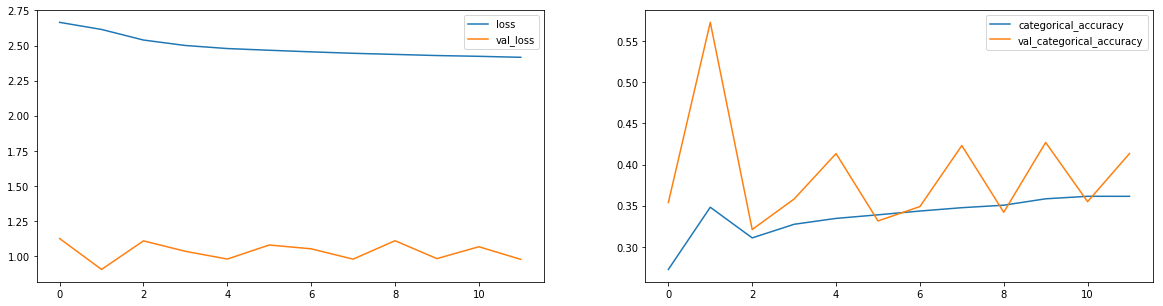

138012/138012 [==============================] - 9s 63us/step
accuracy   0.689570472132858
precision  0.7397252536194243
recall     0.689570472132858
f1_score   0.7113879675485829
[[ 2461  8193  2156]
 [ 9715 88675 14775]
 [ 2005  5999  4033]]
(array([0.17354206, 0.86203544, 0.19237741]), array([0.19211553, 0.78359033, 0.33505026]), array([0.18235708, 0.82094319, 0.24441684]), array([ 12810, 113165,  12037]))
{"auction": "NoAuction"
 "dataset_name": "DecPre"
 "y_type": "y1true"
 "normalization_type": "stock-stationary"
 "split_type": "default"
 "model_name": "DeepLOB"
 "lr": 0.01
 "batch_size": 32
 "accuracy ": 0.689570472132858
 "precision": 0.7397252536194243
 "recall": 0.689570472132858
 "f1_score": 0.7113879675485829
 "training_time": 97
 "epochs_trained": 12}
(394337, 46)
[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

 [[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  [1. 

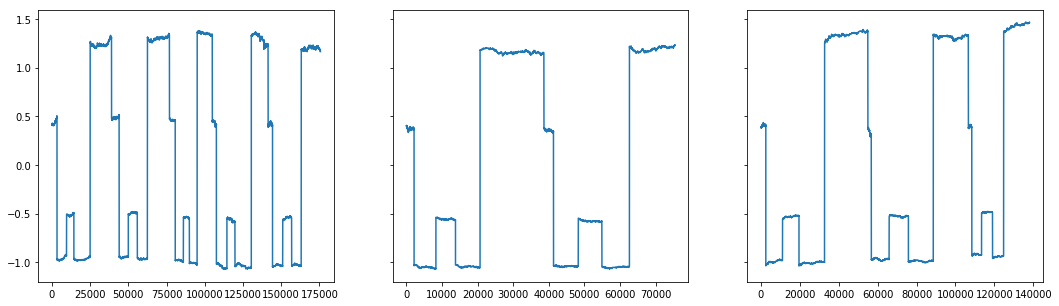

(?, 100, 20, 16)
(?, 100, 20, 16)
(?, 100, 20, 16)
(?, 100, 10, 16)
(?, 100, 10, 16)
(?, 100, 10, 16)
(?, 100, 1, 16)
(?, 100, 16)
(?, 100, 16)
(?, 100, 16)
(?, 100, 32)
(?, 100, 32)
(?, 100, 32)
(?, 100, 32)
(?, 100, 16)
(?, 100, 32)
(?, 100, 96)
(?, 64)
(?, 3)
Train on 175627 samples, validate on 75448 samples
Epoch 1/200
175627/175627 [==============================] - 518s 3ms/step - loss: 2.1861 - categorical_accuracy: 0.1999 - val_loss: 1.1081 - val_categorical_accuracy: 0.3744
Epoch 2/200
175627/175627 [==============================] - 484s 3ms/step - loss: 2.1744 - categorical_accuracy: 0.3209 - val_loss: 1.1386 - val_categorical_accuracy: 0.2725
Epoch 3/200
175627/175627 [==============================] - 484s 3ms/step - loss: 2.1715 - categorical_accuracy: 0.3448 - val_loss: 1.0921 - val_categorical_accuracy: 0.3849
Epoch 4/200
175627/175627 [==============================] - 484s 3ms/step - loss: 2.1684 - categorical_accuracy: 0.3557 - val_loss: 1.1245 - val_categorical_acc

In [ ]:
for y_type in ['y1true', 'y2true', 'y5true']:
    for normalization_type in ['none', 'stock-stationary']:
        model_name = 'DeepLOB'
        
        if 'TABL' in model_name:
            batch_size, lr, input_length = (256, 0.001, 10)
#             auction, dataset_name = ('Auction', 'Zscore')
        elif 'LOB' in model_name:
            batch_size, lr, input_length = (32, 0.01, 100)
#             auction, dataset_name = ('NoAuction', 'Zscore')
            
        if normalization_type == 'none':
            auction, dataset_name = ('NoAuction', 'Zscore')
        else:
            auction, dataset_name = ('NoAuction', 'DecPre')
        
        weighted = True
        class_weight=None
        if weighted==True:
            if y_type=='y1true':
                class_weight={0:7.0, 1:1.0, 2:7.0}
            elif y_type=='y2true':
                class_weight={0:3.5, 1:1.0, 2:3.5}
            elif y_type=='y5true':
                class_weight={0:1.3, 1:1.0, 2:1.3}
                
        output_folder=os.getcwd()+'/output_'+'_'.join(['weighted', y_type, model_name, normalization_type])+'/'
        
        preprocessing_parameters={'auction':auction, 'dataset_name':dataset_name, 'y_type':y_type,
                                  'normalization_type':normalization_type, 'split_type':'default'}
        training_parameters={'model_name': model_name, 'lr': lr, 'batch_size': batch_size}
        gpu_parameters={'gpu_number':0, 'thread_number':1}
        os.mkdir(output_folder)
        data = Preprocessing(**preprocessing_parameters, input_length=input_length)
        GPU_setup(**gpu_parameters)
        model, history, training_time = Train_model(*tuple(data.values())[:4], **training_parameters, 
                                                    output_folder=output_folder, class_weight=class_weight)
        Plot_training_curve(history)
        results = Get_test_results(model, *tuple(data.values())[-2:])
        Save_information(preprocessing_parameters, training_parameters, results, 
                         training_time, history, output_folder)

In [22]:
table_entry=[]
for experiment in list(sorted([i for i in os.listdir() if 'output' in i])):
    table_entry.append([experiment.replace('output_', '').replace('_', ', ')])
    information=json.loads(open(experiment+'/'+'information.json', 'r').read().replace('\n ', ', ')) 
    for key in ['accuracy ','precision','recall','f1_score']:
        table_entry[-1].append(str(round(information[key]*100, 2)))
        table_entry[-1][-1]+=''.join(['0' for i in range(5-len(table_entry[-1][-1]))])
    for key in ['training_time']:
        table_entry[-1].append(str(information[key]))

results=(' \\\\ \n').join([' & '.join(table_entry[i]) for i in range(len(table_entry))])
results = '\\begin{table}[!ht] \n \centering \n \\begin{tabular}{l|c c c c c } \n \hline \n'+ \
' & '.join(['Experiment', 'Accuracy \%', 'Precision \%', 'Recall \%', 'F1 \%', 'Training Time (min)'])+ \
' \\\\ \\hline\n'+results+' \\\\ \\hline\n \end{tabular} \n \caption{} \n \label{} \n\end{table}'

print(results)

\begin{table}[!ht] 
 \centering 
 \begin{tabular}{l|c c c c c } 
 \hline 
Experiment & Accuracy \% & Precision \% & Recall \% & F1 \% & Training Time (min) \\ \hline
 \\ \hline
 \end{tabular} 
 \caption{} 
 \label{} 
\end{table}


In [ ]:
# history=pd.read_csv(output_folder+'history.csv')
# Plot_training_curve(history)
# information = Load_information(output_folder)
# model = Load_model(output_folder)
# results = Get_test_results(model, *tuple(data.values())[-2:])

(394337, 46)
train (175752, 100, 40, 1) (175752, 3)
val (75498, 100, 40, 1) (75498, 3)
test (138087, 100, 40, 1) (138087, 3)


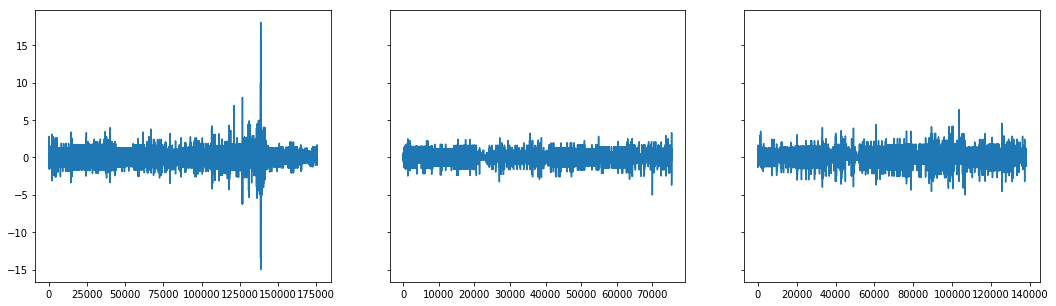

(?, 100, 20, 16)
(?, 100, 20, 16)
(?, 100, 20, 16)


In [23]:
preprocessing_parameters={'auction':'NoAuction',
                          'dataset_name':'DecPre',
                          'y_type':'y2_true',
                          'normalization_type':'sample-stationary',
                          'split_type':'default',
                         }
data = Preprocessing(**preprocessing_parameters, input_length=100)
gpu_parameters={'gpu_number':0, 'thread_number':1}
GPU_setup(**gpu_parameters)
model = Load_model('output_DeepLOB_sample-stationary/')
inputs = Input(shape=data['train_x'].shape[1:])
n_filters=16
alpha,upper_threshold,lower_threshold=(0.01,None,0.0)
layer1_out = ReLU(max_value=upper_threshold, negative_slope=alpha, threshold=lower_threshold)(
    Conv2D(filters=n_filters, kernel_size=(1,2), strides=(1,2))(inputs))
print(layer1_out.shape)
layer2_out = ReLU(max_value=upper_threshold, negative_slope=alpha, threshold=lower_threshold)(
    Conv2D(filters=n_filters, kernel_size=(4,1), padding='same')(layer1_out))
print(layer2_out.shape)
layer3_out = ReLU(max_value=upper_threshold, negative_slope=alpha, threshold=lower_threshold)(
    Conv2D(filters=n_filters, kernel_size=(4,1), padding='same')(layer2_out))
print(layer3_out.shape)
model1 = keras.models.Model(inputs=inputs, outputs=[layer1_out,layer2_out,layer3_out])
for i in range(len(model1.layers)):
    model1.layers[i].set_weights(model.layers[i].get_weights())
outputs = model1.predict(data['test_x'][range(0,len(data['test_x']),100)], batch_size=2048, verbose=1)
print([i.shape for i in outputs])

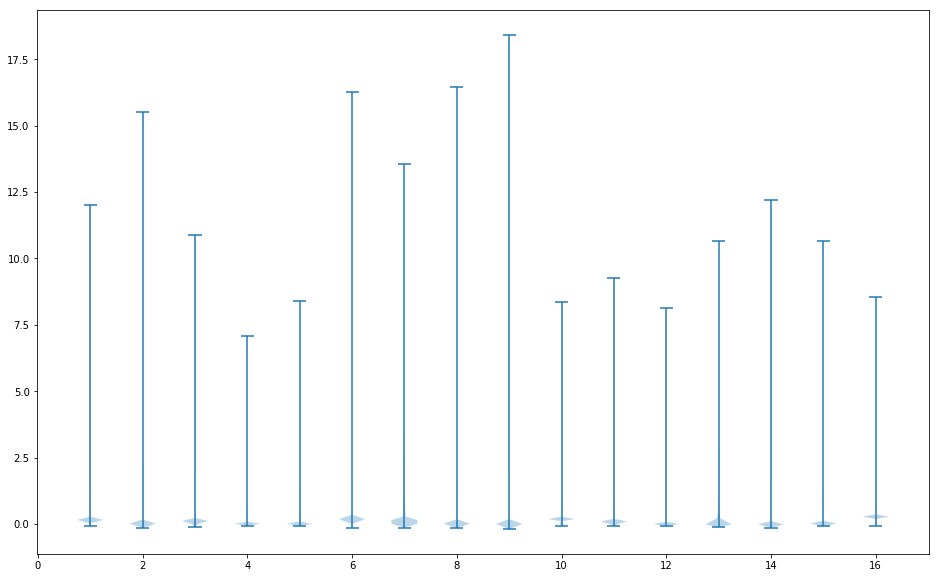

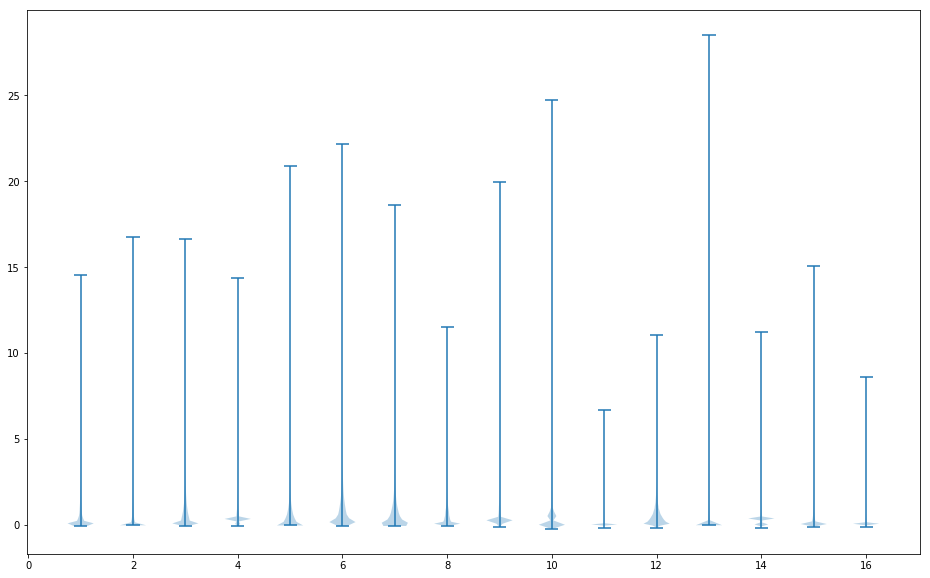

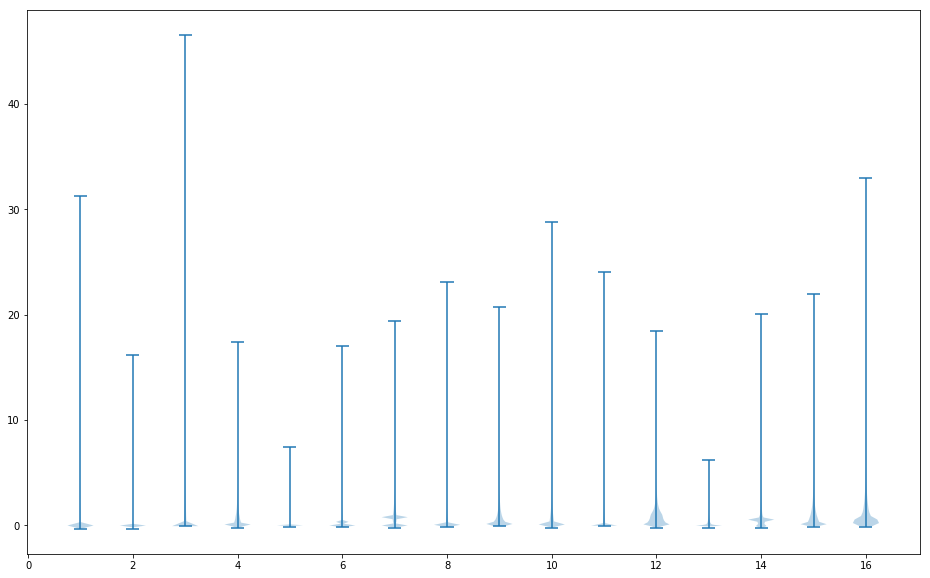

In [27]:
f=[]
for output in outputs:
    f.append(plt.figure(figsize=(16,10)))
    _=f[-1].gca().violinplot(output.reshape(-1,16))
    _=plt.show()

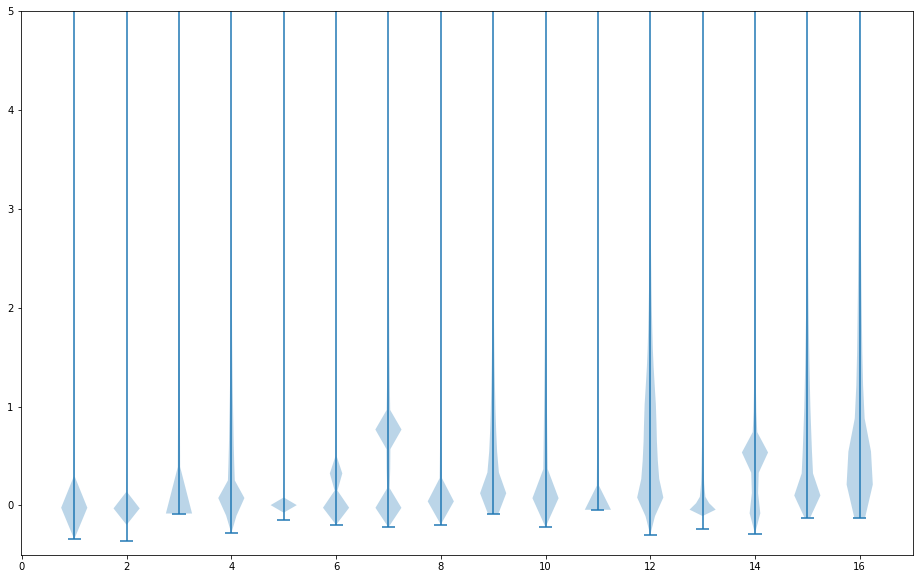

In [41]:
g=f
[i.gca().set_ylim([-0.5,5]) for i in g]
g[2]

In [26]:
data = np.load('NoAuction_DecPre.npy')
mid_price = np.mean(data[:,[0,2]], axis=1)
a=np.round(np.abs(mid_price-np.roll(mid_price, 1)), 15)
half_tick=np.amin(a[a>0])
print(half_tick, np.amin(mid_price), np.amax(mid_price), 100*half_tick/np.amax(mid_price), 
      0.5*100*half_tick/np.amax(mid_price), 0.2*100*half_tick/np.amax(mid_price))

5e-05 0.12025 0.37835 0.013215276860050218 0.006607638430025109 0.0026430553720100435
